In [1]:
import sys
sys.path.append("../src")
import numpy as np
import pandas as pd
from opt_summary import OptSummary
from sd_summary import SDSummary
from no_del_summary import NoDeletionSummary
import time
from utils import *
import stopit
plt.rc('axes', axisbelow=True)

@stopit.threading_timeoutable(default=(np.nan, np.nan))
def exec_summary(s, values, f, k, beta, jit=False):
    start_time = time.time()
    if s == 'NO DEL':
        test = NoDeletionSummary(values, f, beta)
        err = test.summarize()
    elif s == 'DS':
        values, f = outlier_removal(values, f, del_percentage)
        test = NoDeletionSummary(values, f, beta)
        err = test.summarize()
    elif s == 'SD CON':
        test = SDSummary(values, f, beta, k, method='con')
        err = test.summarize(k)
    elif s == 'SD ARB':
        test = SDSummary(values, f, beta, k, method='arb')
        err = test.summarize(k)
    elif s == 'CON': 
        test = OptSummary(values, f, beta, k, method='con')
        if jit == True:
            test.jit = True
        err = test.summarize(k)
    elif s == 'ARB':
        test = OptSummary(values, f, beta, k, method='arb')
        err = test.summarize(k)
        
    elapsed = (time.time() - start_time)
    return err, elapsed, test

### In the cell below you can specify the parameters for the experiments.
- timeout: In seconds. Choose how long a summary is allowed to run before stoping its execution.
- dataset: Uncomment one of the three available datasets.
- frac: float in [0.0, 0.1]. Percentage of the dataset to be uniformely sampled. The experiments will be run on that sample. The default value is 0.10 a smaller value will make the experiments run faster due to the smaller size. However the results might not be that reliable. Higher values will lead to slower execution times.


In [2]:
timeout = 120

dataset = 'cars'
#dataset = 'capital'
#dataset = 'hours'
if dataset == 'hours':
    file = '../data/hours_per_week.csv'
elif dataset == 'cars':
    file = '../data/cars_year_produced.csv'
elif dataset == 'capital':
    file = '../data/capital_gain.csv'

frac = 0.1
    
data_name = file.split('/')[2].rstrip('.csv')
print(f'Dataset: {data_name}')

Dataset: cars_year_produced


### Loading the dataset

In [3]:
df = pd.read_csv(file, header=None)
df = df.sample(frac = frac, random_state=0)
df = df.loc[:,0].value_counts()
df = df.sort_index()
values = df.index.values
f = df.values

### We are now going to create a histogram on the sample of the dataset that we got with 10 buckets and 2% of the dataset size as deletions, as those are the default parameters used in the paper. Then we are going to visualise the histograms that the different algorithms provide.

In [4]:
beta = 10
del_percentage = 0.02
k = int(np.sum(f) * del_percentage)


err, elapsed, s = exec_summary('SD CON', values, f, k, beta, timeout=timeout)
sd_con_left, sd_con_right, sd_con_n = s.getBucketRanges()
sd_con_err = err
sd_con_time = elapsed

err, elapsed, s = exec_summary('NO DEL', values, f, k, beta, timeout=timeout)
nd_left, nd_right, nd_n = s.getBucketRanges()
no_del_err = err
no_del_time = elapsed


err, elapsed, s = exec_summary('CON', values, f, k, beta,jit=True ,timeout=timeout)
con_left, con_right, con_n = s.getBucketRanges()
con_err = err
con_time = elapsed

### First we are going to compare a v-optimal histogram with no deletions to the algorithm SD CON that deletes outliers on the buckets created by the no deletion algorithm in order ot minimize variance

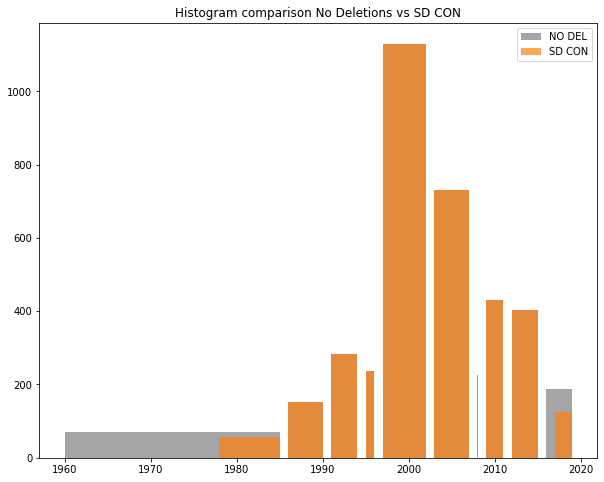

In [5]:
left_edges = [values[nd_left], values[sd_con_left]]#, values[con_left]]
right_edges = [values[nd_right], values[sd_con_right]]#, values[con_right]]
ns = [nd_n, sd_con_n]
color = ['tab:gray', 'tab:orange']
labels = ['NO DEL', 'SD CON']
j = 0
plt.figure(figsize=(10,8))
plt.title('Histogram comparison No Deletions vs SD CON')
for left, right, n in zip(left_edges, right_edges, ns):
    buckets = []
    widths = []
    for i in range(len(left)):
        buckets.append(left[i]+right[i])
        width = right[i]-left[i]
        if width == 0:
            width = 0.1
        widths.append(width)
    plt.bar(np.array(buckets)/2, n, width=widths, color=color[j], alpha=0.7, label=labels[j])
    plt.legend()
    j += 1
plt.show()

### Next we are going to compare a v-optimal histogram with no deletions to the algorithm CON that deletes outliers while creating the histogram.

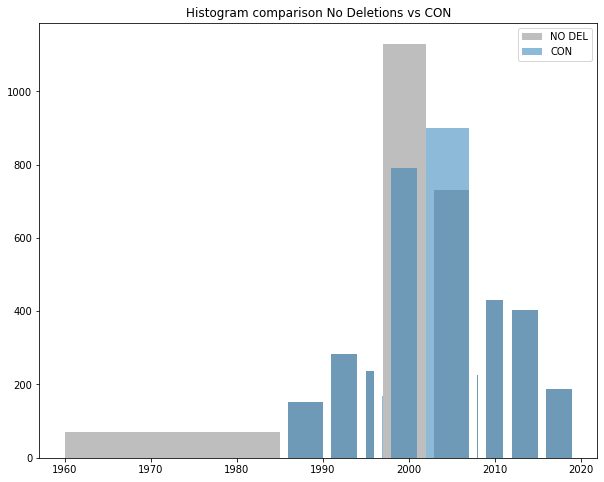

In [6]:
    
    
left_edges = [values[nd_left], values[con_left]]
right_edges = [values[nd_right], values[con_right]]
ns = [nd_n, con_n]
color = ['tab:gray', 'tab:blue']
labels = ['NO DEL', 'CON']
j = 0
plt.figure(figsize=(10,8))
plt.title('Histogram comparison No Deletions vs CON')
for left, right, n in zip(left_edges, right_edges, ns):
    buckets = []
    widths = []
    for i in range(len(left)):
        buckets.append(left[i]+right[i])
        width = right[i]-left[i]
        if width == 0:
            width = 0.1
        widths.append(width)
    plt.bar(np.array(buckets)/2, n, width=widths, color=color[j], alpha=0.5, label=labels[j])
    plt.legend()
    j += 1
plt.show()

### Finally lets see a simple execution example

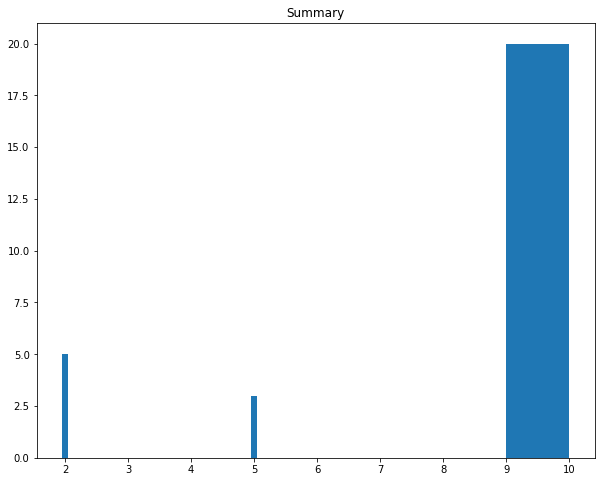

In [7]:
values = np.array([1, 2, 5, 7, 9 ,10, 25])
f = np.array([1, 5, 3, 1, 10 ,10, 3])
beta = 3
k = 5
err, elapsed, s = exec_summary('CON', values, f, k, beta,jit=True ,timeout=timeout)
con_left, con_right, con_n = s.getBucketRanges()
plot_histogram(values[con_left], values[con_right], con_n)